In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '15/10/2021'
id_noticia = '268929'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'
dias_grafico = 180

In [3]:
def DrawMediaFlotante (dfData, provincia, dias):   
    data = dfData.loc[provincia].diff().tail(dias).copy()
    data['Media Positivo 7 dias'] = data['PCR Positivo'].rolling(window=7).mean()
    data['Media Positivo 14 dias'] = data['PCR Positivo'].rolling(window=14).mean()
    titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia
    # print(titulo + '. (Nuevos positivos e ingresos hospitalarios)')
    data[['Hospitalización', 'PCR Positivo', 'Media Positivo 7 dias', 'Media Positivo 14 dias']].plot(
        kind='line', grid=True, figsize=(15,5), title=titulo)
    plt.xticks(
        rotation=45,    
        horizontalalignment='right',
        fontweight='light',
    )
    plt.show()
    

In [4]:
def DrawMediasDiarias(dfData, provincia, variable, dias):
    data = pd.DataFrame(dfData.loc[provincia][variable].tail(dias).copy())
    data.columns = [variable]
    data['Media 7 dias'] = data[variable].rolling(window=7).mean()
    data['Media 14 dias'] = data[variable].rolling(window=14).mean()
    data['Media 28 dias'] = data[variable].rolling(window=28).mean()
    data.plot(title= variable + ' por día en ' + provincia, figsize=(15,5), grid=True, color = ['lightgrey', 'green', 'orange', 'red'])
    plt.xticks(
        rotation=45,    
        horizontalalignment='right',
        fontweight='light',
    )
    plt.show()


In [5]:
# FIX SSL: CERTIFICATE_VERIFY_FAILED with Python3
# https://stackoverflow.com/a/49174340
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[len(tables) - 1] # Last table

In [7]:
# Prepare
dfL.columns = ['Provincia', 'PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']
dfL['Fecha'] = fecha
regex = r"(\d*\.?\d*)"

for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    # dfL[col] = dfL[col].str.extract(regex, expand=False).astype(float).fillna(0).apply(lambda x : '{0:,}'.format(x))
    dfL[col] = dfL[col].str.extract(regex, expand=False).fillna(0).apply(lambda x : str(x).replace('.', '')).astype(int)
    # .astype(float).fillna(0).apply(lambda x : '{0:,}'.format(x))
    
    # df[c] = df[c].apply(lambda x : '{0:,}'.format(x))
dfL


,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,70300,4437,757,925,69002,15/10/2021
1,Cádiz,112619,6708,688,1614,110419,15/10/2021
2,Córdoba,72259,5318,660,1088,71165,15/10/2021
3,Granada,109010,9175,1170,1873,107162,15/10/2021
4,Huelva,45579,2820,214,418,44619,15/10/2021
5,Jaén,64018,5207,489,1087,63309,15/10/2021
6,Málaga,154996,10485,1009,1978,153172,15/10/2021
7,Sevilla,176377,12863,1252,2309,172909,15/10/2021
8,Total,805158,57013,6239,11292,791757,15/10/2021


In [8]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
# data.sample(5)

In [9]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [10]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
# dfL.tail()

In [11]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [12]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [13]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').diff()
# dfV.tail()

In [14]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]
dfG

,variable,Curados,Fallecimientos,Hospitalización,PCR Positivo,UCI
Provincia,Fecha,,,,,
Almería,2021-10-15,61.0,0.0,2.0,48.0,0.0
Cádiz,2021-10-15,16.0,2.0,1.0,18.0,0.0
Córdoba,2021-10-15,18.0,2.0,3.0,27.0,0.0
Granada,2021-10-15,23.0,4.0,1.0,31.0,1.0
Huelva,2021-10-15,21.0,0.0,2.0,38.0,0.0
Jaén,2021-10-15,6.0,1.0,2.0,17.0,0.0
Málaga,2021-10-15,86.0,0.0,2.0,69.0,2.0
Sevilla,2021-10-15,87.0,-2.0,7.0,49.0,0.0
Total,2021-10-15,318.0,7.0,20.0,297.0,3.0


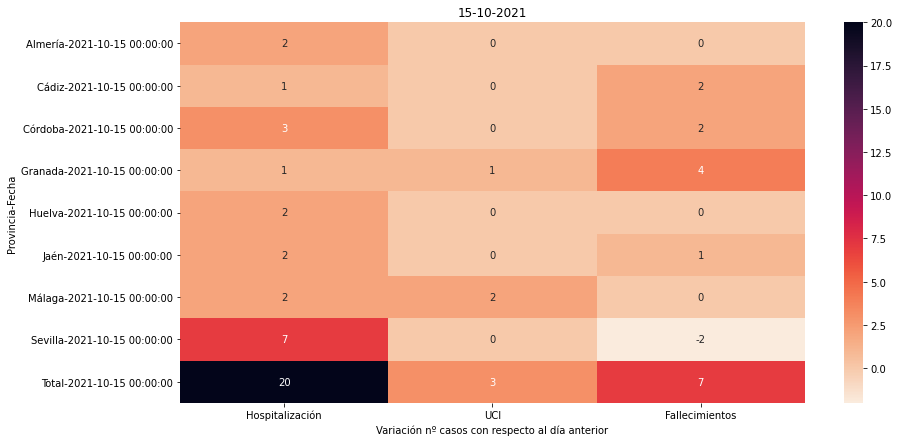

In [15]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap,fmt='g')

# Add label for horizontal axis
plt.xlabel('Variación nº casos con respecto al día anterior')
plt.show()

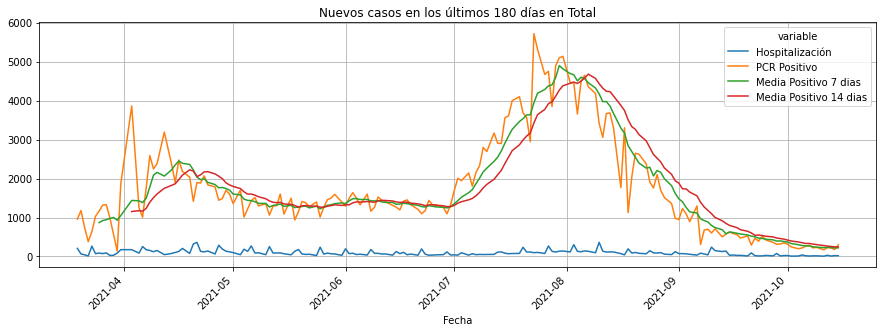

In [16]:
DrawMediaFlotante(df, 'Total', dias_grafico)

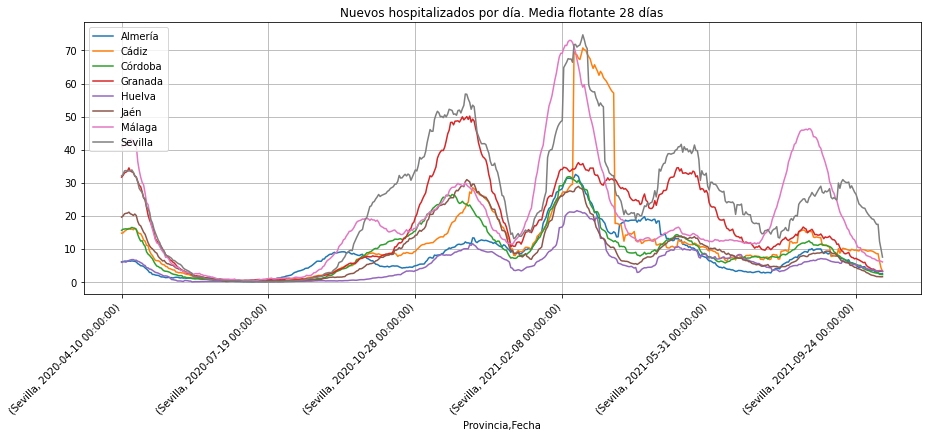

In [17]:
dias = 28
data = dfV['Hospitalización'].rolling(window=dias).mean().dropna().drop('Total')
data.groupby('Provincia').plot(title='Nuevos hospitalizados por día. Media flotante ' + str(dias) + ' días', figsize=(15,5), grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.legend(loc='upper left')
plt.show()

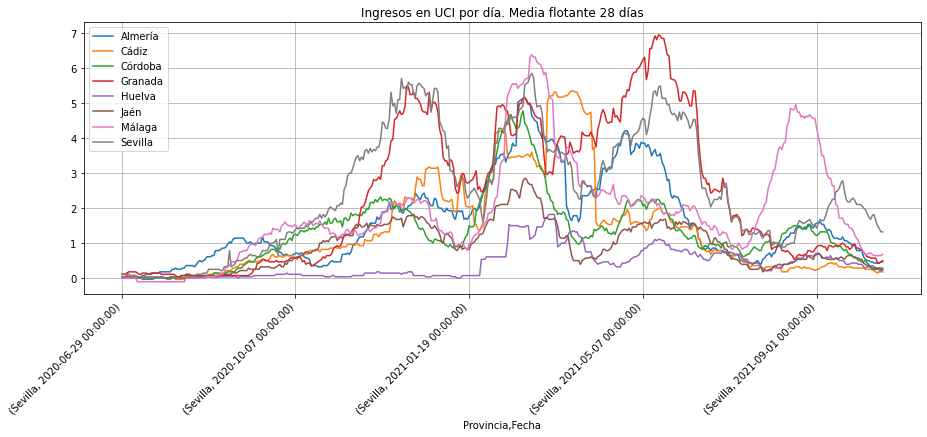

In [18]:
dias = 28
data = dfV['UCI'].rolling(window=dias).mean().dropna().drop('Total')
data.groupby('Provincia').plot(title='Ingresos en UCI por día. Media flotante ' + str(dias) + ' días', figsize=(15,5), grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.legend(loc='upper left')
plt.show()

In [19]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'Hospitalización'], ascending=[False, True])

variable,Fecha,Hospitalización,dias
Provincia,,,
Granada,2021-10-15,1.0,0 days
Cádiz,2021-10-15,1.0,0 days
Málaga,2021-10-15,2.0,0 days
Jaén,2021-10-15,2.0,0 days
Huelva,2021-10-15,2.0,0 days
Almería,2021-10-15,2.0,0 days
Córdoba,2021-10-15,3.0,0 days
Sevilla,2021-10-15,7.0,0 days
Total,2021-10-15,20.0,0 days


In [20]:
# Positivos por cada Hospitalización
dfG['PCR Positivo']/dfG['Hospitalización']

Provincia  Fecha     
Almería    2021-10-15    24.00
Cádiz      2021-10-15    18.00
Córdoba    2021-10-15     9.00
Granada    2021-10-15    31.00
Huelva     2021-10-15    19.00
Jaén       2021-10-15     8.50
Málaga     2021-10-15    34.50
Sevilla    2021-10-15     7.00
Total      2021-10-15    14.85
dtype: float64

In [21]:
# Fecha de último ingreso en UCI
data = df[['UCI']].diff()
data = data[data['UCI'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'UCI'], ascending=[False, True])

variable,Fecha,UCI,dias
Provincia,,,
Jaén,2021-09-28,2.0,17 days
Huelva,2021-10-08,1.0,7 days
Córdoba,2021-10-13,1.0,2 days
Cádiz,2021-10-13,1.0,2 days
Sevilla,2021-10-14,1.0,1 days
Almería,2021-10-14,1.0,1 days
Granada,2021-10-15,1.0,0 days
Málaga,2021-10-15,2.0,0 days
Total,2021-10-15,3.0,0 days


In [22]:
# Fecha de último Fallecimiento
data = df[['Fallecimientos']].diff()
data = data[data['Fallecimientos'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'Fallecimientos'], ascending=[False, True])

variable,Fecha,Fallecimientos,dias
Provincia,,,
Huelva,2021-10-12,2.0,3 days
Málaga,2021-10-14,1.0,1 days
Almería,2021-10-14,1.0,1 days
Sevilla,2021-10-14,2.0,1 days
Jaén,2021-10-15,1.0,0 days
Córdoba,2021-10-15,2.0,0 days
Cádiz,2021-10-15,2.0,0 days
Granada,2021-10-15,4.0,0 days
Total,2021-10-15,7.0,0 days


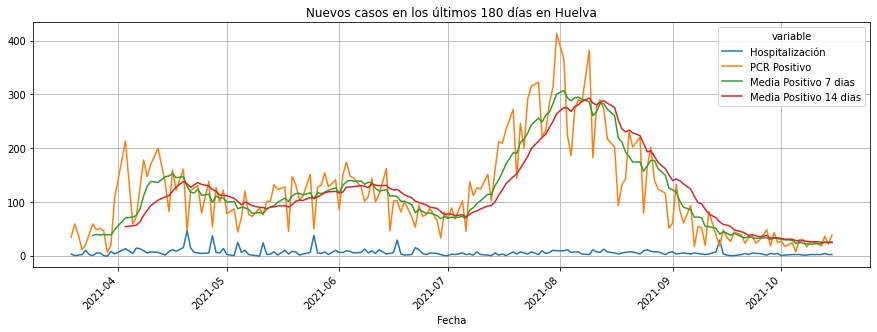

In [23]:
DrawMediaFlotante(df, 'Huelva', dias_grafico)

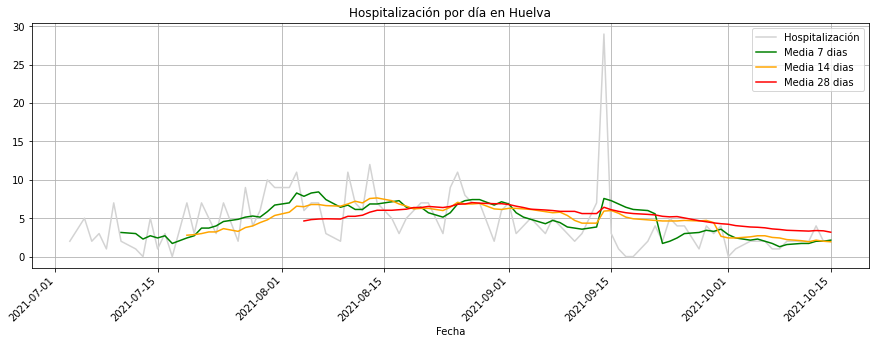

In [24]:
DrawMediasDiarias(dfV, 'Huelva', 'Hospitalización', 90)

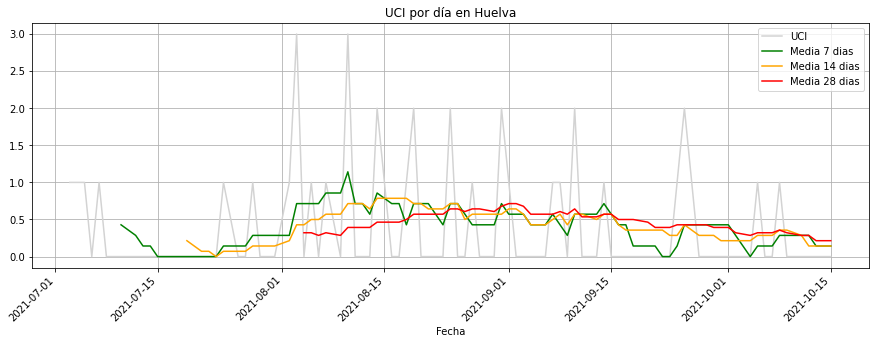

In [25]:
DrawMediasDiarias(dfV, 'Huelva', 'UCI', 90)

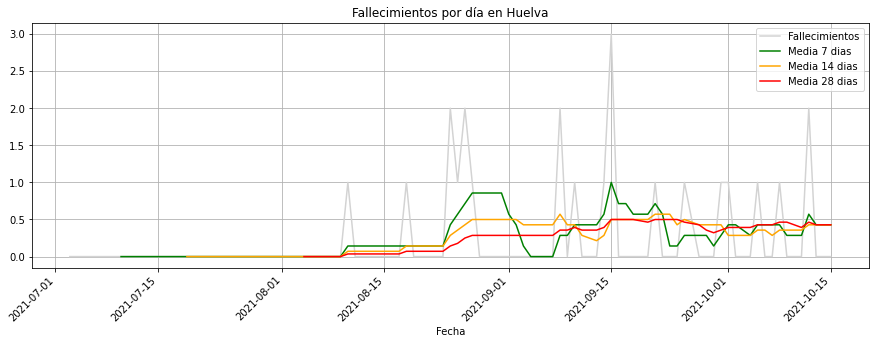

In [26]:
DrawMediasDiarias(dfV, 'Huelva', 'Fallecimientos', 90)

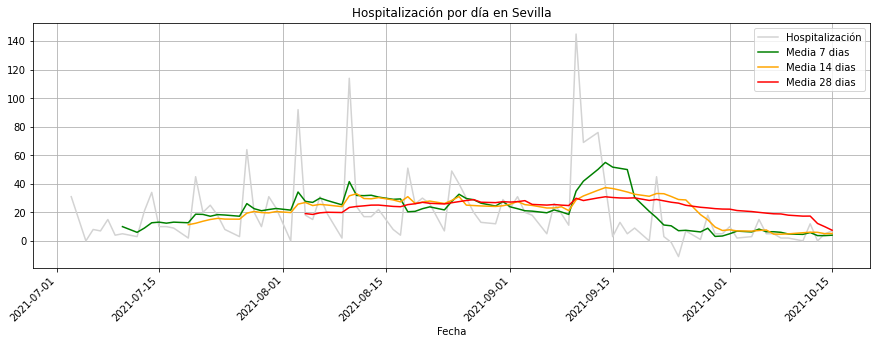

In [27]:
DrawMediasDiarias(dfV, 'Sevilla', 'Hospitalización', 90)

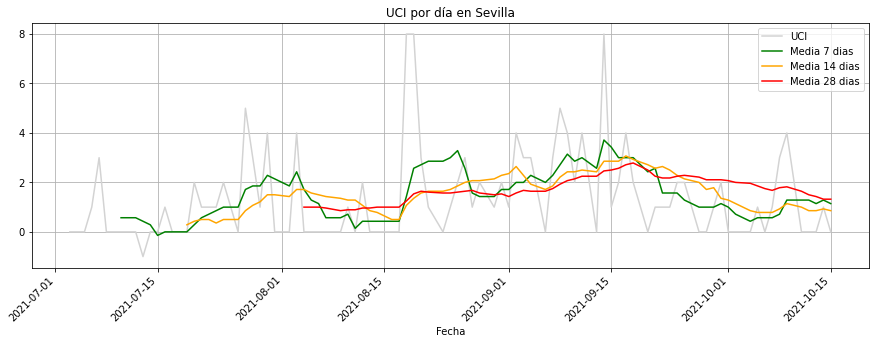

In [28]:
DrawMediasDiarias(dfV, 'Sevilla', 'UCI', 90)

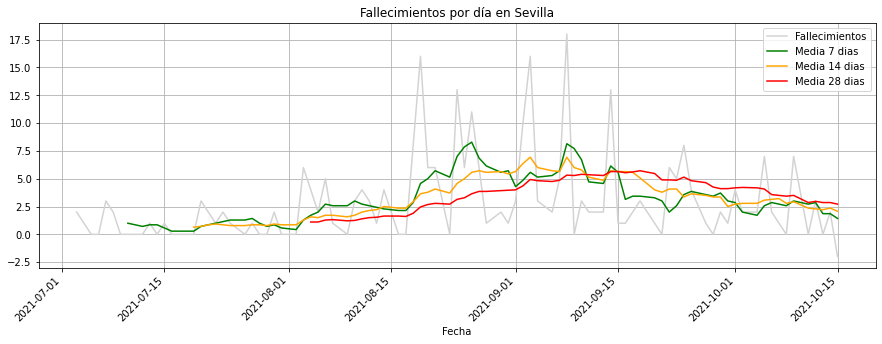

In [29]:
DrawMediasDiarias(dfV, 'Sevilla', 'Fallecimientos', 90)

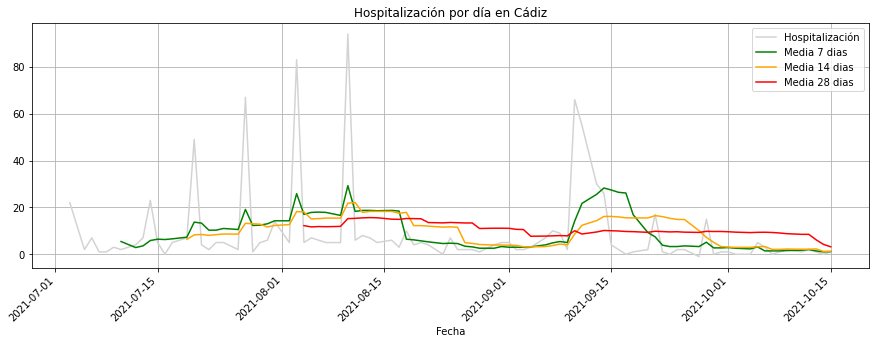

In [30]:
DrawMediasDiarias(dfV, 'Cádiz', 'Hospitalización', 90)

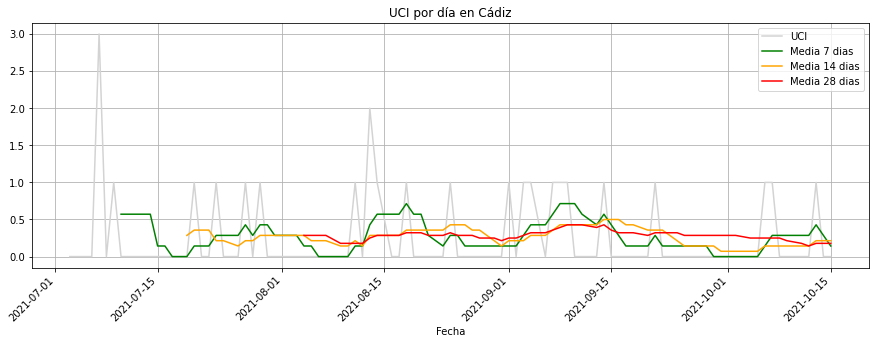

In [31]:
DrawMediasDiarias(dfV, 'Cádiz', 'UCI', 90)

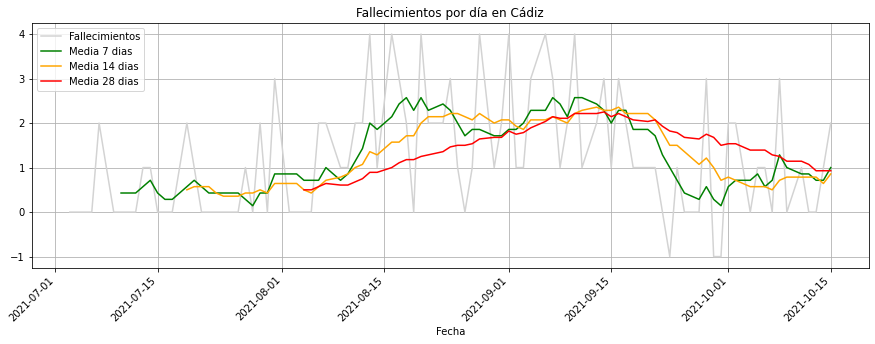

In [32]:
DrawMediasDiarias(dfV, 'Cádiz', 'Fallecimientos', 90)

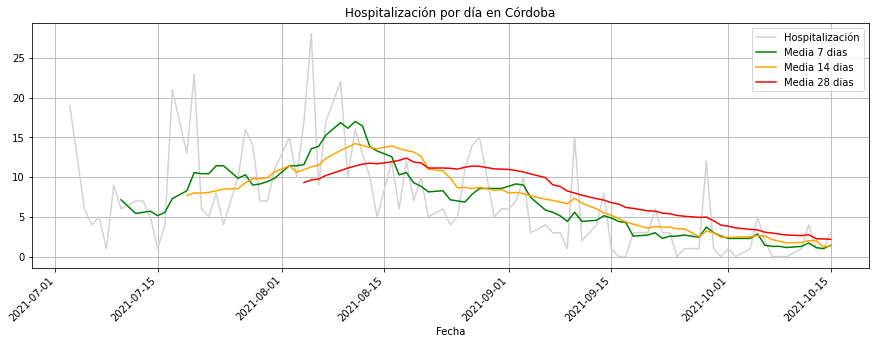

In [33]:
DrawMediasDiarias(dfV, 'Córdoba', 'Hospitalización', 90)

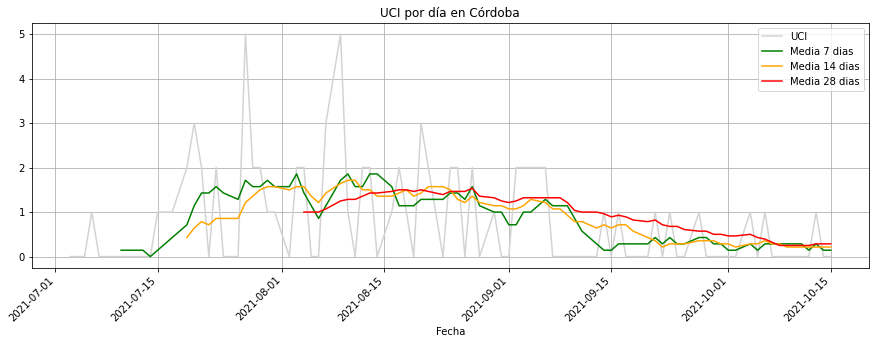

In [34]:
DrawMediasDiarias(dfV, 'Córdoba', 'UCI', 90)

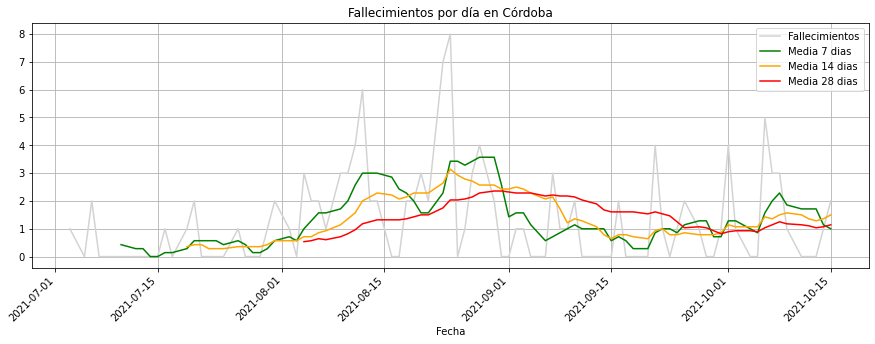

In [35]:
DrawMediasDiarias(dfV, 'Córdoba', 'Fallecimientos', 90)

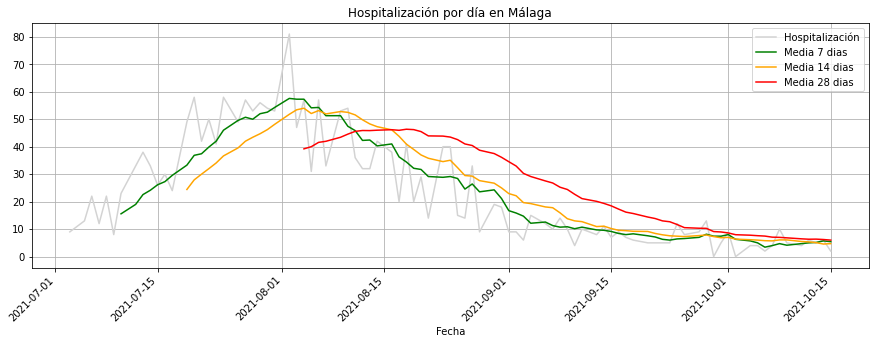

In [36]:
DrawMediasDiarias(dfV, 'Málaga', 'Hospitalización', 90)

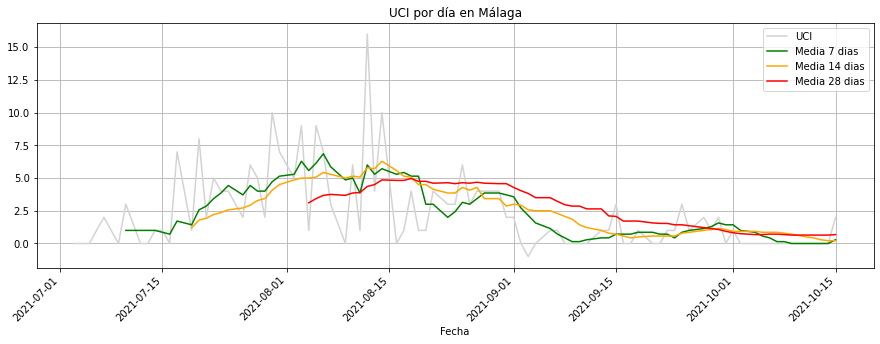

In [37]:
DrawMediasDiarias(dfV, 'Málaga', 'UCI', 90)

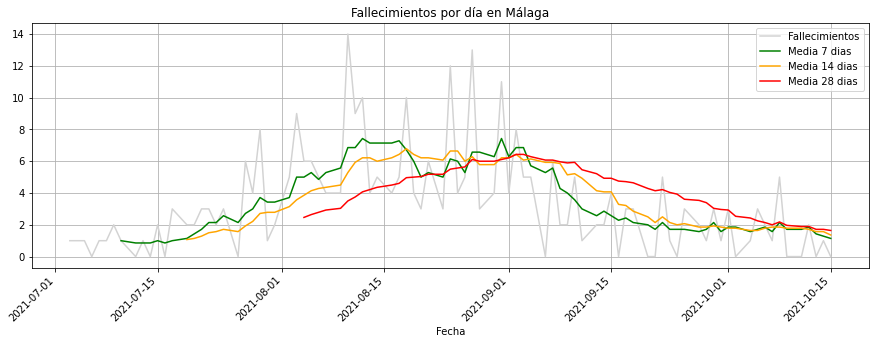

In [38]:
DrawMediasDiarias(dfV, 'Málaga', 'Fallecimientos', 90)

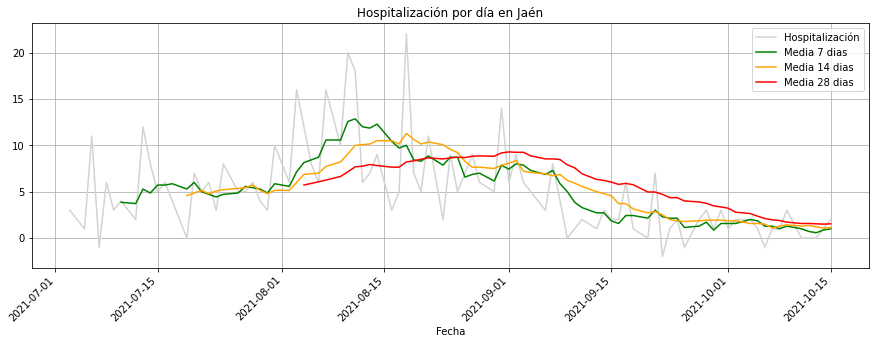

In [39]:
DrawMediasDiarias(dfV, 'Jaén', 'Hospitalización', 90)

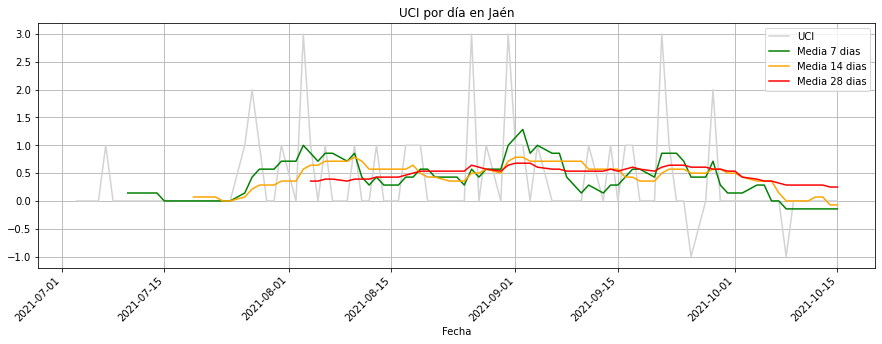

In [40]:
DrawMediasDiarias(dfV, 'Jaén', 'UCI', 90)

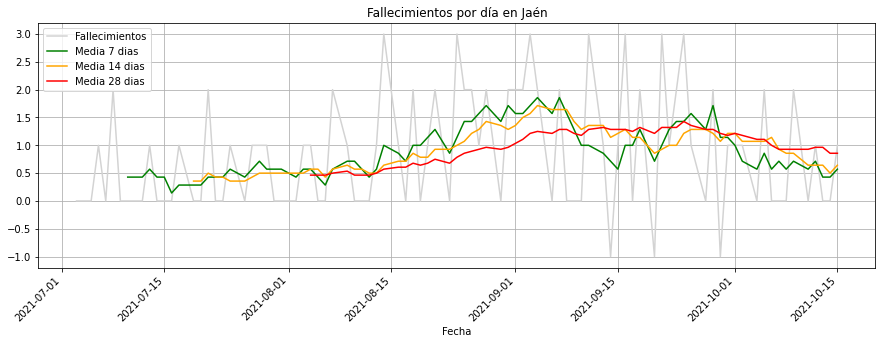

In [41]:
DrawMediasDiarias(dfV, 'Jaén', 'Fallecimientos', 90)

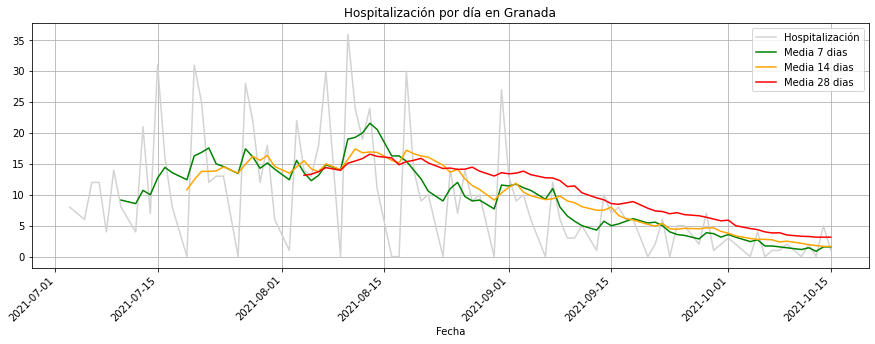

In [42]:
DrawMediasDiarias(dfV, 'Granada', 'Hospitalización', 90)

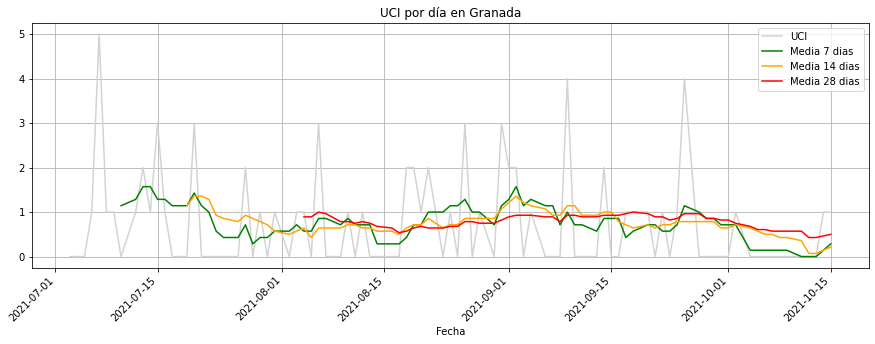

In [43]:
DrawMediasDiarias(dfV, 'Granada', 'UCI', 90)

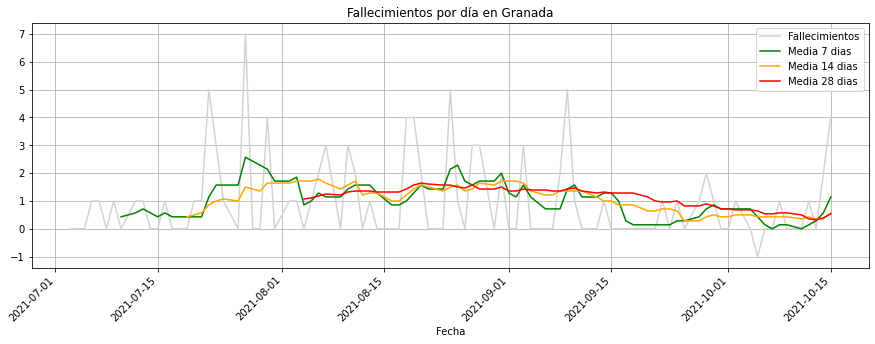

In [44]:
DrawMediasDiarias(dfV, 'Granada', 'Fallecimientos', 90)

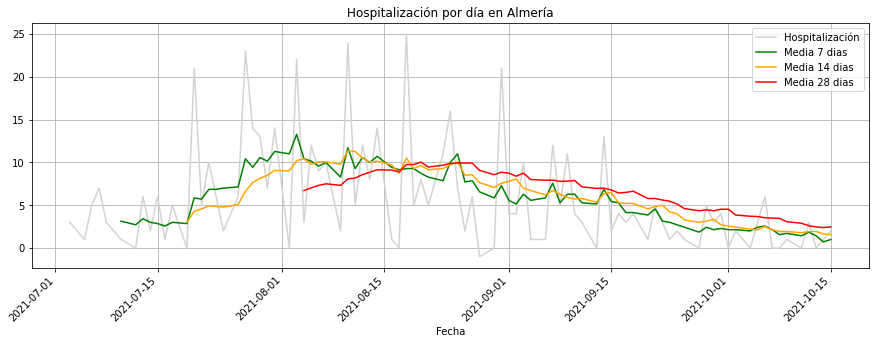

In [45]:
DrawMediasDiarias(dfV, 'Almería', 'Hospitalización', 90)

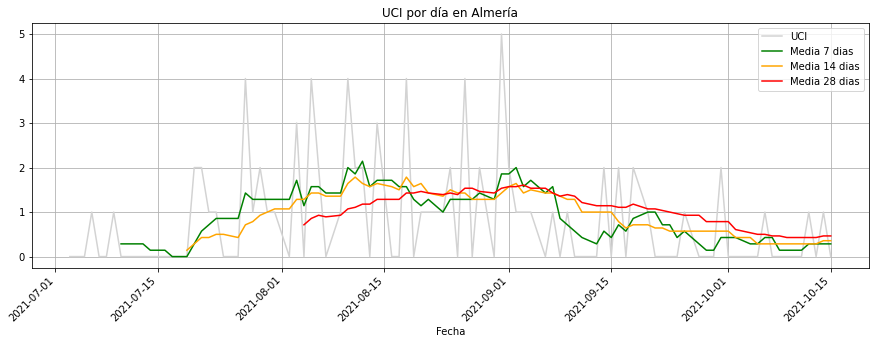

In [46]:
DrawMediasDiarias(dfV, 'Almería', 'UCI', 90)

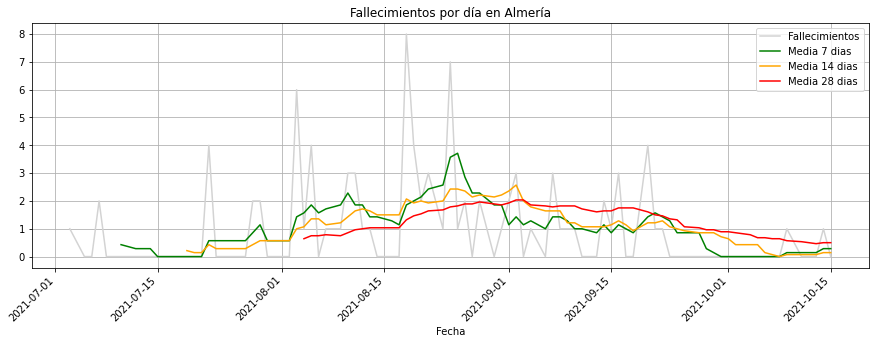

In [47]:
DrawMediasDiarias(dfV, 'Almería', 'Fallecimientos', 90)